# Classifying Fashion-MNIST

We'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST.

<img src='assets/fashion-mnist-sprite.png' width="500" />

First off, let's load the dataset through torchvision.

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

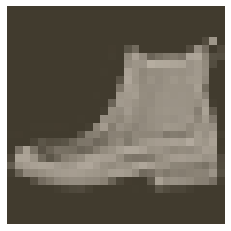

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

With the data loaded, it's time to import the necessary packages.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

from torch import nn
from torch import optim
import torch.nn.functional as F

## Building the network

As with MNIST, each image in Fashion-MNIST is 28x28 which is a total of 784 pixels, and there are 10 classes. We're going to get a bit more advanced here, we want to be able to build a network with an arbitrary number of hidden layers. That is, we want to pass in a parameter like `hidden_layers = [512, 256, 128]` and the network is contructed with three hidden layers have 512, 256, and 128 units respectively. To do this, we'll use `nn.ModuleList` to allow for an arbitrary number of hidden layers. Using `nn.ModuleList` works pretty much the same as a normal Python list, except that it registers each hidden layer `Linear` module properly so the model is aware of the layers.

The issue here is we need a way to define each `nn.Linear` module with the appropriate layer sizes. Since each `nn.Linear` operation needs an input size and an output size, we need something that looks like this:

```python
# Create ModuleList and add input layer
hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
# Add hidden layers to the ModuleList
hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
```

Getting these pairs of input and output sizes can be done with a handy trick using `zip`.

```python
hidden_layers = [512, 256, 128, 64]
layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
for each in layer_sizes:
    print(each)

>> (512, 256)
>> (256, 128)
>> (128, 64)
```

We also have the `forward` method returning the log-softmax for the output. Since softmax is a probability distibution over the classes, the log-softmax is a log probability which comes with a [lot of benefits](https://en.wikipedia.org/wiki/Log_probability). Using the log probability, computations are often faster and more accurate. To get the class probabilities later, we'll need to take the exponential (`torch.exp`) of the output.

$$ \large{e^{\ln{x}} = x }$$

We can include dropout in our network with [`nn.Dropout`](http://pytorch.org/docs/master/nn.html#dropout). This works similar to other modules such as `nn.Linear`. It also takes the dropout probability as an input which we can pass as an input to the network.

In [4]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

# Train the network

Since the model's forward method returns the log-softmax, we used the [negative log loss](http://pytorch.org/docs/master/nn.html#nllloss) as our criterion, `nn.NLLLoss()`. We also chose to use the [Adam optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Adam). This is a variant of stochastic gradient descent which includes momentum and in general trains faster than basic SGD.

We've also included a block to measure the validation loss and accuracy. Since we'm using dropout in the network, we need to turn it off during inference. Otherwise, the network will appear to perform poorly because many of the connections are turned off. PyTorch allows us to set a model in "training" or "evaluation" modes with `model.train()` and `model.eval()`, respectively. In training mode, dropout is turned on, while in evaluation mode, dropout is turned off. This effects other modules as well that should be on during training but off during inference.

The validation code consists of a forward pass through the validation set (also split into batches). With the log-softmax output, we calculate the loss on the validation set, as well as the prediction accuracy.

In [5]:
# Implement a function for the validation pass
def validation(model, testloader, criterion, input_size):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images.resize_(images.size()[0], input_size)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(dim=1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [6]:
def train(model, trainloader, testloader, criterion, optimizer, input_size, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], input_size)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion, input_size)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

In [7]:
# Hyper parameters

input_size = 784
output_size = 10
hidden_layers = [516, 256]

In [8]:
# Create the network, define the criterion and optimizer
model = Network(input_size, output_size, hidden_layers)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
train(model, trainloader, testloader, criterion, optimizer, input_size, epochs=20, print_every=400)

Epoch: 1/20..  Training Loss: 0.724..  Test Loss: 0.498..  Test Accuracy: 0.813
Epoch: 1/20..  Training Loss: 0.534..  Test Loss: 0.455..  Test Accuracy: 0.836
Epoch: 2/20..  Training Loss: 0.500..  Test Loss: 0.450..  Test Accuracy: 0.835
Epoch: 2/20..  Training Loss: 0.478..  Test Loss: 0.435..  Test Accuracy: 0.846
Epoch: 3/20..  Training Loss: 0.476..  Test Loss: 0.420..  Test Accuracy: 0.846
Epoch: 3/20..  Training Loss: 0.450..  Test Loss: 0.416..  Test Accuracy: 0.842
Epoch: 3/20..  Training Loss: 0.456..  Test Loss: 0.414..  Test Accuracy: 0.847
Epoch: 4/20..  Training Loss: 0.430..  Test Loss: 0.394..  Test Accuracy: 0.860
Epoch: 4/20..  Training Loss: 0.440..  Test Loss: 0.393..  Test Accuracy: 0.857
Epoch: 5/20..  Training Loss: 0.423..  Test Loss: 0.396..  Test Accuracy: 0.860
Epoch: 5/20..  Training Loss: 0.423..  Test Loss: 0.385..  Test Accuracy: 0.860
Epoch: 6/20..  Training Loss: 0.419..  Test Loss: 0.396..  Test Accuracy: 0.854
Epoch: 6/20..  Training Loss: 0.408..  T

## Inference

Now that the model is trained, we can use it for inference. We need to remember to set the model in inference mode with `model.eval()`. We'll also want to turn off autograd with the `torch.no_grad()` context.

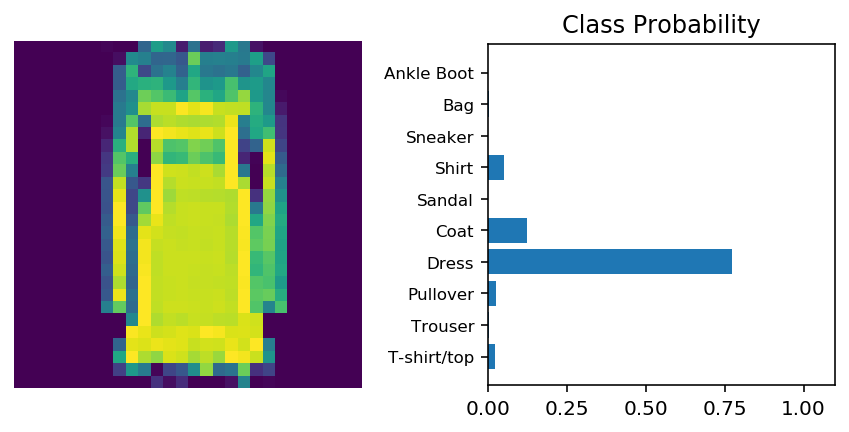

In [17]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Accuracy Testing

In [11]:
# Final Testing Accuracy

model.eval()
accuracy = 0
for images, labels in iter(testloader):

        images.resize_(images.shape[0], 784)
        with torch.no_grad():
            output = model.forward(images)
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.879


## Saving the model

In [12]:
checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_layers,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint1.pth')

## Loading the model

In [13]:
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'])

    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [14]:
model = load_checkpoint('checkpoint1.pth')

## Accuracy Testing

In [15]:
# Final Testing Accuracy

model.eval()
accuracy = 0
for images, labels in testloader:

        images.resize_(images.shape[0], 784)
        with torch.no_grad():
            output = model.forward(images)
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.879
